https://ui.adsabs.harvard.edu/abs/2022ApJ...929...68O/abstract Olguin


In [1]:
from astropy import units as u
distance=3.25*u.kpc # Olguin
vcen = -46.9 * u.km/u.s # from Fernando's paper (https://ui.adsabs.harvard.edu/abs/2022ApJ...929...68O/abstract)


In [2]:
cd /orange/adamginsburg/salt/sanhueza/G335/

/orange/adamginsburg/salt/sanhueza/G335


In [3]:
ls

cutout2.reg
cutout.reg
G335.579-0.272.config8.cont_avg.selfcal_0.5_hogbom.image.fits
G335.579-0.272.config8.spw0.robust0.5.image_co1_smaller.fits
G335.579-0.272.config8.spw0.robust0.5.image_co2_smaller.fits
G335.579-0.272.config8.spw0.robust0.5.image_small.fits
G335.579-0.272.config8.spw1.robust0.5.image_co1_smaller.fits
G335.579-0.272.config8.spw1.robust0.5.image_co2_smaller.fits
G335.579-0.272.config8.spw1.robust0.5.image_small.fits
G335.579-0.272.config8.spw2.robust0.5.image_co1_smaller.fits
G335.579-0.272.config8.spw2.robust0.5.image_co2_smaller.fits
G335.579-0.272.config8.spw2.robust0.5.image_small.fits
G335.579-0.272.config8.spw3.robust0.5.image_co1_smaller.fits
G335.579-0.272.config8.spw3.robust0.5.image_co2_smaller.fits
G335.579-0.272.config8.spw3.robust0.5.image_small.fits
G335.zip
ipython_log_2021-09-30.py
NaCl_v_le_3_stackcube.fits
spectra/


In [4]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b3fcaa3e370>

In [5]:
from astropy.table import Table
from astropy import table

In [6]:
import pprint

In [7]:
import scipy, scipy.ndimage

In [8]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from astropy import visualization
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [9]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('cutout.reg')
reg2 = regions.Regions.read('cutout2.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [10]:
reg[0].center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (335.58504754, -0.29013032)>

Setting the 'color' property will override the edgecolor or facecolor properties.
Setting the 'color' property will override the edgecolor or facecolor properties.


(2452.0, 2697.0, 2474.0, 2759.0)

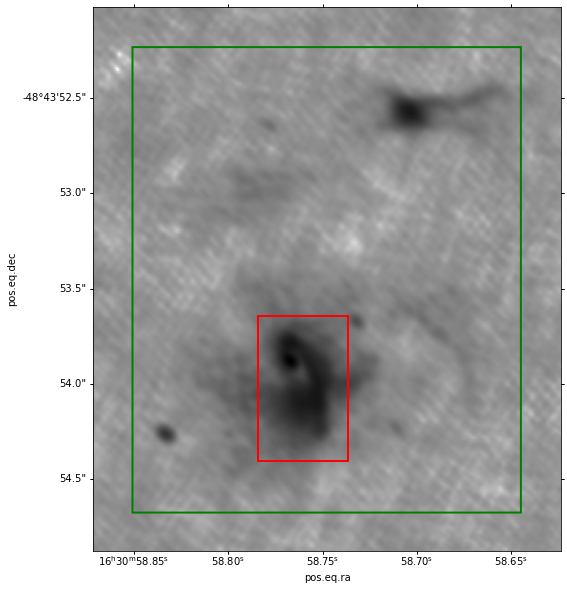

In [11]:
cont = SpectralCube.read('G335.579-0.272.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r', norm=visualization.simple_norm(cont[0].value, stretch='log'))
reg[0].to_pixel(cont[0].wcs).plot(ax=ax, color='g')
reg2[0].to_pixel(cont[0].wcs).plot(ax=ax, color='r')
#regvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
#regvvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

# NaCl Stackl

In [12]:
from spectral_cube.analysis_utilities import stack_cube

In [13]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [14]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [15]:
flist = (glob.glob('G335.579-0.272.config8.spw[0-3].robust0.5.image_small.fits'))

In [16]:
for fn in flist:
    for rr,regn in ((reg, 'co1'), (reg2, 'co2')):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile) or SpectralCube.read(outfile).unit != u.K:
            cube = SpectralCube.read(fn).subcube_from_regions(rr)
            cube.allow_huge_operations=True
            cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
            scube = cube.convolve_to(cb).to(u.K)
            scube.write(outfile, overwrite=True)

In [17]:
regn = "co1"
cubes = [SpectralCube.read(fn, use_dask=True).subcube_from_regions(reg)
         for fn in (glob.glob(f'G335.579-0.272.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]

cubes

[DaskSpectralCube with shape=(3840, 244, 204) and unit=K and chunk size (320, 244, 204):
  n_x:    204  type_x: RA---SIN  unit_x: deg    range:   247.744354 deg:  247.745209 deg
  n_y:    244  type_y: DEC--SIN  unit_y: deg    range:   -48.731851 deg:  -48.731176 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 219062705741.457 Hz:220937327148.900 Hz,
 DaskSpectralCube with shape=(3840, 244, 204) and unit=K and chunk size (320, 244, 204):
  n_x:    204  type_x: RA---SIN  unit_x: deg    range:   247.744354 deg:  247.745209 deg
  n_y:    244  type_y: DEC--SIN  unit_y: deg    range:   -48.731851 deg:  -48.731176 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 233562706825.600 Hz:235437328233.043 Hz,
 DaskSpectralCube with shape=(3840, 244, 204) and unit=K and chunk size (320, 244, 204):
  n_x:    204  type_x: RA---SIN  unit_x: deg    range:   247.744354 deg:  247.745209 deg
  n_y:    244  type_y: DEC--SIN  unit_y: deg    range:   -48.731851 deg:  -48.731176 deg
  n_s: 

In [18]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()

In [19]:
cb

Beam: BMAJ=0.07390272439563746 arcsec BMIN=0.06439214331607895 arcsec BPA=44.9813758663128 deg

In [20]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 240.18385429 AU>

In [21]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 209.27446578 AU>

In [22]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [23]:
from astropy import log
log.setLevel('INFO')

In [24]:
#log.setLevel('DEBUG')
vcen = -46.9 * u.km/u.s # from Fernando's paper (https://ui.adsabs.harvard.edu/abs/2022ApJ...929...68O/abstract)
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [25]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits', use_dask=True)
stackc

DaskSpectralCube with shape=(90, 244, 204) and unit=K and chunk size (90, 244, 204):
 n_x:    204  type_x: RA---SIN  unit_x: deg    range:   247.744354 deg:  247.745209 deg
 n_y:    244  type_y: DEC--SIN  unit_y: deg    range:   -48.731851 deg:  -48.731176 deg
 n_s:     90  type_s: VRAD      unit_s: km / s  range:      -76.857 km / s:     -17.086 km / s

In [26]:
jtok = stackc.beam.jtok(217*u.GHz)

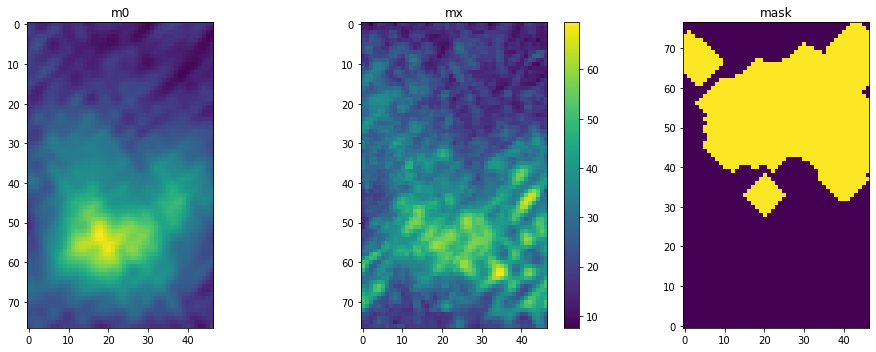

<Figure size 432x288 with 0 Axes>

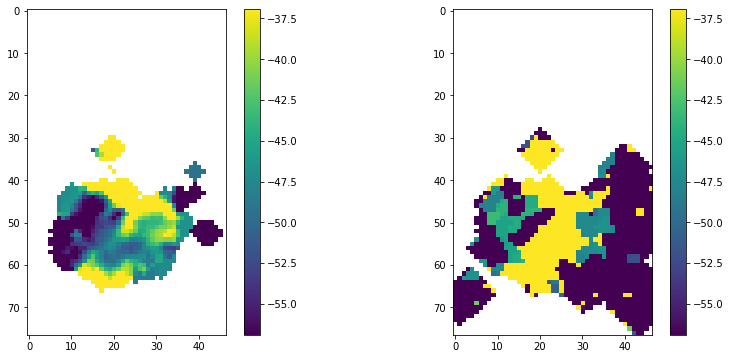

In [27]:
stackc = stackc.subcube_from_regions(reg2)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 40*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (stackc > 30*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()


m1 = stackc.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar()


vmap = m1.hdu

In [28]:
vcen

<Quantity -46.9 km / s>

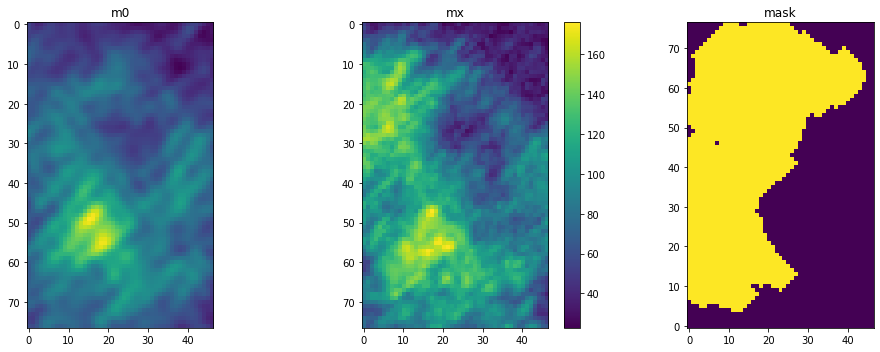

<Figure size 432x288 with 0 Axes>

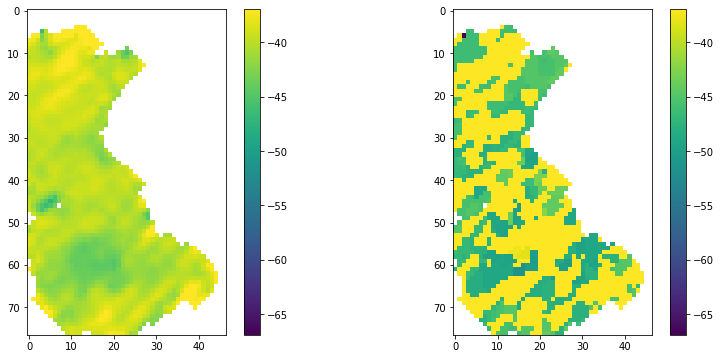

In [29]:
# try creating a vmap based on another line
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
restval = 218.440063*u.GHz # CH3OH 4-3
restval = 219.993658*u.GHz # Methanol! based on Fernando's paper
#restval = 219.94944000*u.GHz # SO 65-54
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
scube = (cube.subcube_from_regions(reg2)
         .with_spectral_unit(u.km/u.s,
                                                          velocity_convention='radio',
                                                          rest_value=restval)
         .spectral_slab(vcen-30*u.km/u.s, vcen+30*u.km/u.s))
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 100*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=4)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 50*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()




m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-20, vmax=vcen.value+10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-20, vmax=vcen.value+10)
pl.colorbar()


#vmap = m1.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

In [30]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [31]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(reg2).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [32]:
mkdir -p spectra/figures

spw1
spw2
spw3
spw4


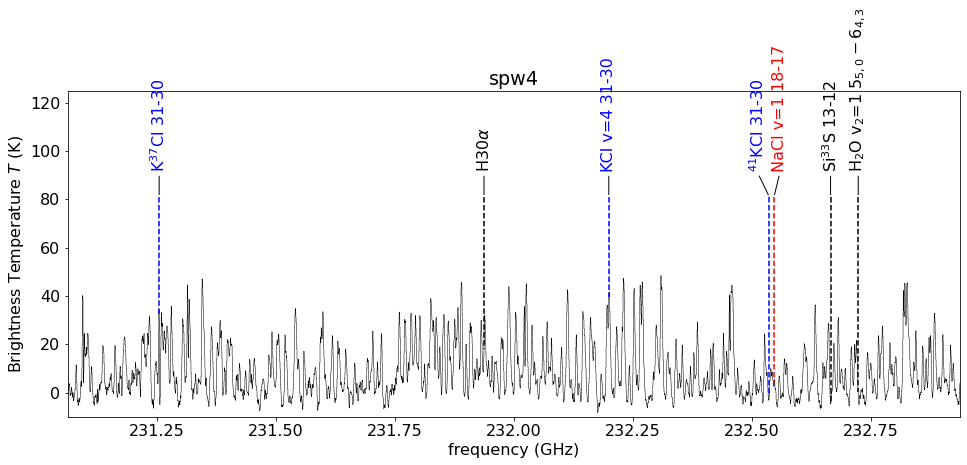

In [33]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures', ymin=-10, ymax=125)

In [34]:
ls spectra/figures

color_labels_G335_spw0_stack.png
color_labels_G335_spw1_stack.png
color_labels_G335_spw2_stack.png
color_labels_G335_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
G335.579-0.272.config8.spw0.robust0.5.image_co1_smaller_stack.pdf
G335.579-0.272.config8.spw0.robust0.5.image_co1_smaller_stack.png
G335.579-0.272.config8.spw1.robust0.5.image_co1_smaller_stack.pdf
G335.579-0.272.config8.spw1.robust0.5.image_co1_smaller_stack.png
G335.579-0.272.config8.spw2.robust0.5.image_co1_smaller_stack.pdf
G335.579-0.272.config8.spw2.robust0.5.image_co1_smaller_stack.png
G335.579-0.272.config8.spw3.robust0.5.image_co1_smaller_stack.pdf
G335.579-0.272.config8.spw3.robust0.5.image_co1_smaller_stack.png
G335_spw0_stack.png
G335_spw1_stack.png
G335_spw2_stack.png
G335_spw3_stack.png
spw1.png
spw2.png
spw3.png
spw4.png


In [35]:
from IPython.display import Image,display

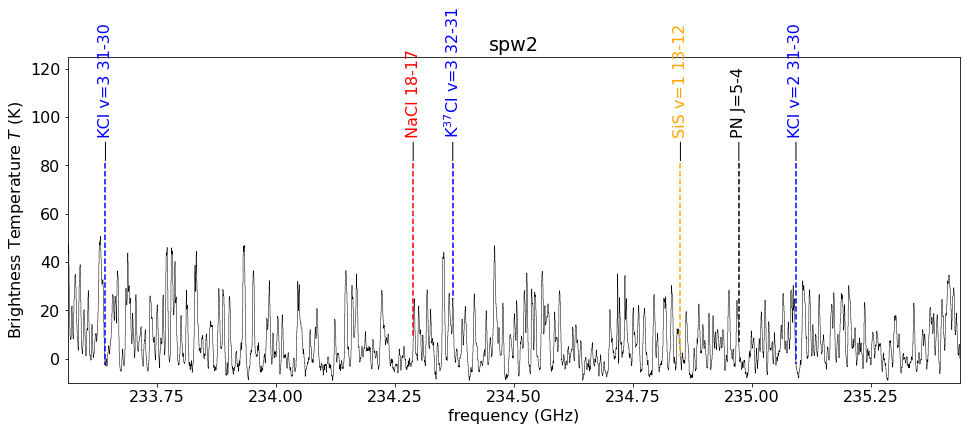

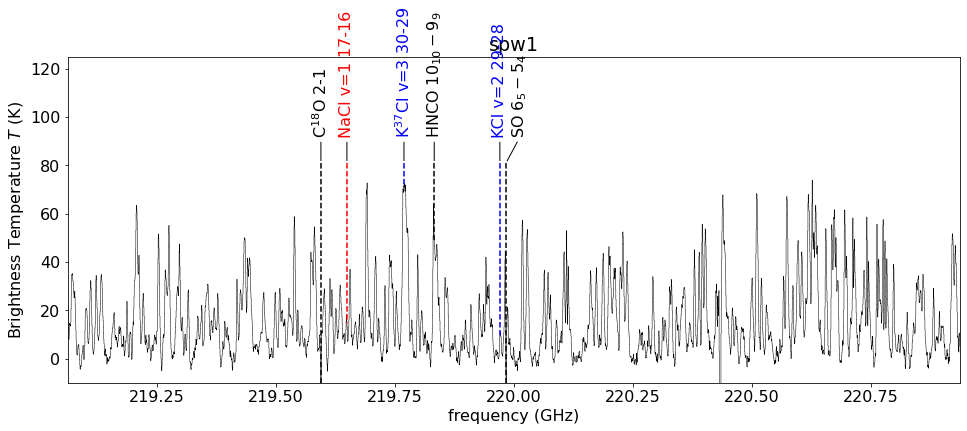

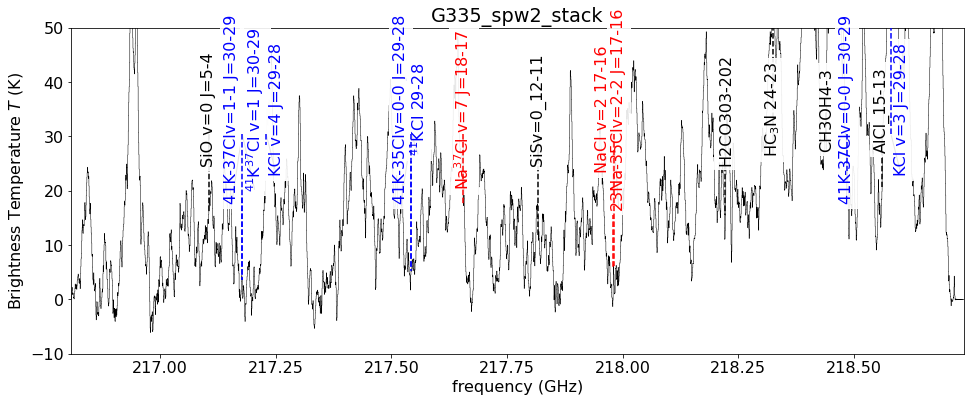

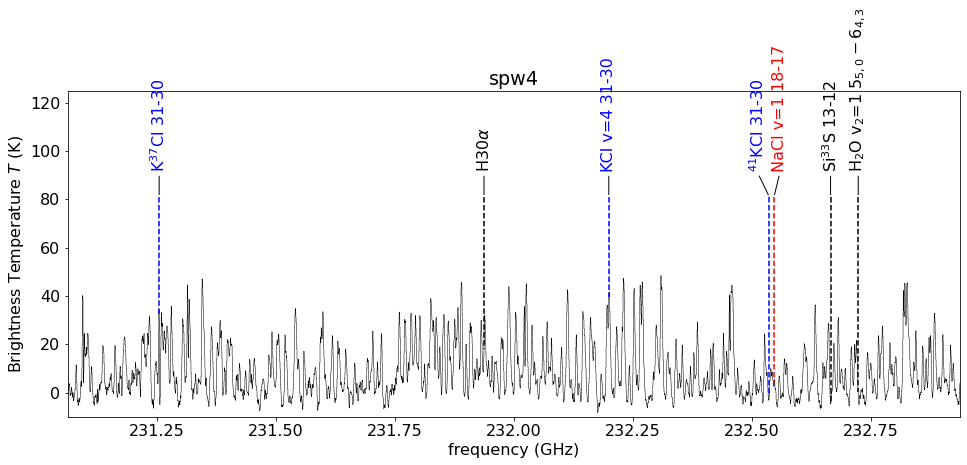

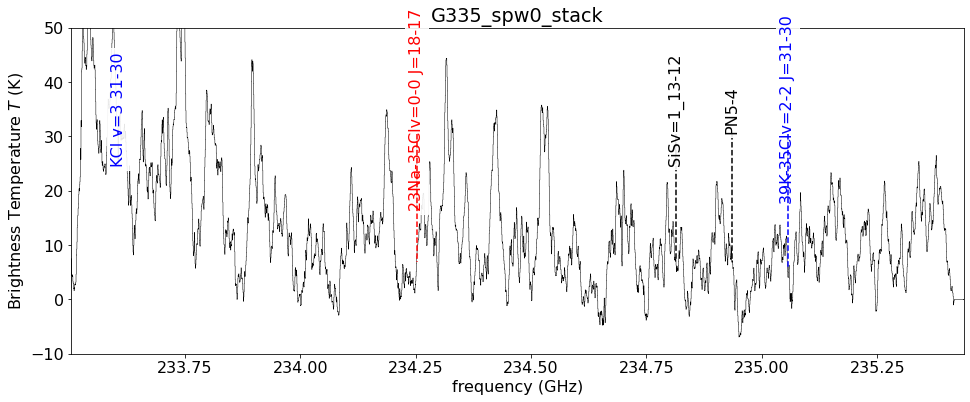

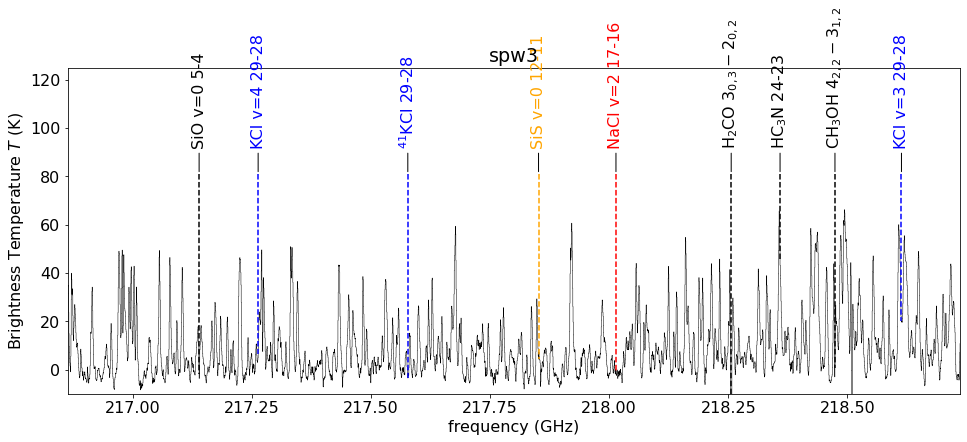

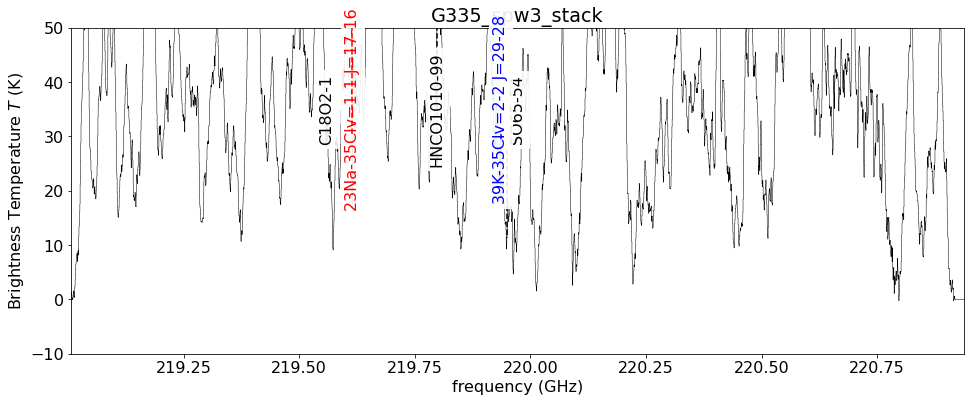

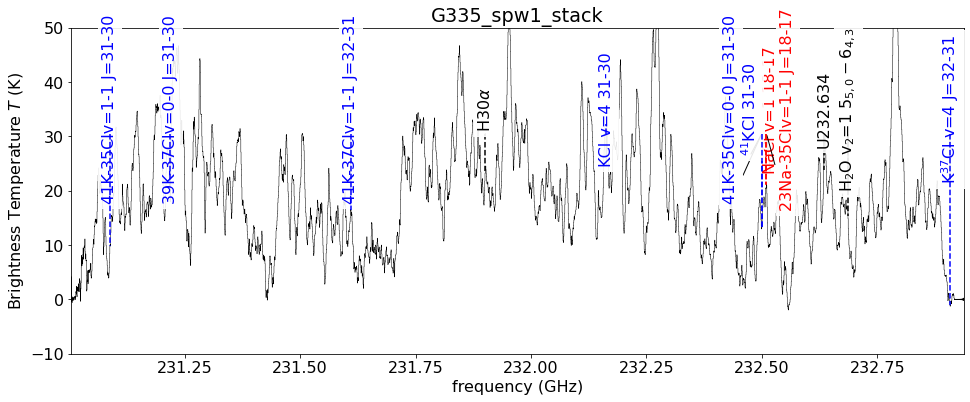

In [36]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

In [37]:
ls

cutout2.reg
cutout.reg
G335.579-0.272.config8.cont_avg.selfcal_0.5_hogbom.image.fits
G335.579-0.272.config8.spw0.robust0.5.image_co1_smaller.fits
G335.579-0.272.config8.spw0.robust0.5.image_co2_smaller.fits
G335.579-0.272.config8.spw0.robust0.5.image_small.fits
G335.579-0.272.config8.spw1.robust0.5.image_co1_smaller.fits
G335.579-0.272.config8.spw1.robust0.5.image_co2_smaller.fits
G335.579-0.272.config8.spw1.robust0.5.image_small.fits
G335.579-0.272.config8.spw2.robust0.5.image_co1_smaller.fits
G335.579-0.272.config8.spw2.robust0.5.image_co2_smaller.fits
G335.579-0.272.config8.spw2.robust0.5.image_small.fits
G335.579-0.272.config8.spw3.robust0.5.image_co1_smaller.fits
G335.579-0.272.config8.spw3.robust0.5.image_co2_smaller.fits
G335.579-0.272.config8.spw3.robust0.5.image_small.fits
G335.zip
ipython_log_2021-09-30.py
NaCl_v_le_3_stackcube.fits
spectra/


In [ ]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm
from astropy.io import fits

cbflist = (glob.glob('G335.579-0.272.config8.spw[0-3].robust0.5.image_co1_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(reg2) # cutout2
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_cutout2_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    fits.PrimaryHDU(data=vmap_proj.value, header=scube.wcs.celestial.to_header()).writeto('vmap.fits', overwrite=True)
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_cutout2_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_cutout2_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_cutout2_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

DaskSpectralCube with shape=(3840, 244, 204) and unit=K and chunk size (320, 244, 204):
 n_x:    204  type_x: RA---SIN  unit_x: deg    range:   247.744354 deg:  247.745209 deg
 n_y:    244  type_y: DEC--SIN  unit_y: deg    range:   -48.731851 deg:  -48.731176 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 219062705741.457 Hz:220937327148.900 Hz
Mean spectrum
Stacking


In [ ]:
ls spectra

In [ ]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]}_{spl[4]}_stack'
    stackspectra.append(pysp)

In [ ]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures', ymin=-10, ymax=50)

In [ ]:
ls spectra/figures/

In [ ]:
for fn in glob.glob('spectra/figures/color*stack.png'):
    display(Image(fn))